# Model comparison

Comparing random forest, deep neural net, and linear model (as a kind of baseline) at predicting **mean** and **sd** of **hill1** for samples from the feasible set given **s** and **n**. 

# Plan

## Data

`new_samples.csv` is about 500 (slightly fewer) records of s, n, and mean and sd of the first hill number over 1000 draws from the feasible set for that s and n. The combinations are randomly distributed within the space of s ranging from 2-200 and n ranging from 3-20000. 

I am currently (4/13) working on generating a larger dataset on the intuition that that will ultimately improve model fit. 

Objective here isn't inference or mechanistic interpretation, it's generating accurate predictions of the mean and sd for new combinations of s and n (that are still within the general sampling space covered by the training set). Ultimately I would like to use the trained model to generate parameters for a normal distribution from which to generate expected distributions of hill numbers from the feasible set (without having to spend the time/compute to actually manually sample that specific feasible set). 

## Models

### Random forest

Using the default behaviors of sklearn.ensemble.RandomForestRegressor.

### Deep neural net

Using keras, a two input model with a couple of deep layers. Following the basic Auto MPG tutorial.

### Linear model

Using the implementation shown the Auto MPG tutorial, as a baseline (I don't expect the lm to perform very well; I know this to be a highly nonlinear relationship).

## Testing

### Data

Use the same train/test split to train and evaluate all models.

### Vis

1:1 plots in a multipanel.

### Metrics

`.score`, if it works for all the model types?


## Setup

In [1]:
# for everything

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# for neural net
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_addons.metrics import RSquare

# for random forest

from sklearn.ensemble import RandomForestRegressor


2023-04-18 13:28:11.432119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/renatadiaz/anaconda3/envs/tf/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Data

In [2]:
rawdat = pd.read_csv('../1500_samples.csv')
len(rawdat)

1476

In [3]:
dat = rawdat.copy()
dat.tail()

,richness,abundance,n,mean,sd,n_hill1
1471,200,11334,1000,108.700899,8.140022,1000
1472,200,16264,1000,114.095688,7.378388,1000
1473,200,18176,1000,115.714174,7.305470,1000
1474,200,18810,1000,115.768178,7.304358,1000
1475,200,19221,1000,116.492614,7.400681,1000


Text(0.5, 1.0, 'n')

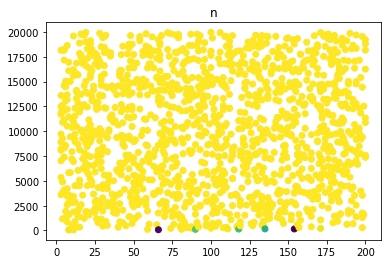

In [4]:
plt.scatter(dat['richness'], dat['abundance'], c= dat['n_hill1'])
plt.title("n")

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.471e+03]),
 array([   2. ,  101.8,  201.6,  301.4,  401.2,  501. ,  600.8,  700.6,
         800.4,  900.2, 1000. ]),
 <BarContainer object of 10 artists>)

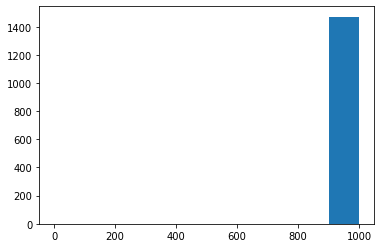

In [5]:
plt.hist(dat['n_hill1'])

In [6]:
incomplete_samples = dat[(dat['n_hill1'] < 1000)]

In [7]:
incomplete_samples

,richness,abundance,n,mean,sd,n_hill1
49,8,57,1000,5.805385,0.958979,979
67,11,66,1000,7.721707,1.281572,992
439,59,114,1000,37.151640,4.935951,997
479,66,74,1000,60.859855,1.665737,22
603,81,127,1000,56.021971,5.471330,991
674,90,114,1000,73.546380,4.229879,732
841,111,166,1000,76.984057,6.966191,992
881,118,142,1000,99.786297,4.621559,694
1007,135,158,1000,116.836821,4.808484,624
1142,154,156,1000,152.995833,0.256713,2


In [8]:
dat = dat[(dat['n_hill1'] == 1000)]

Text(0.5, 1.0, 'n')

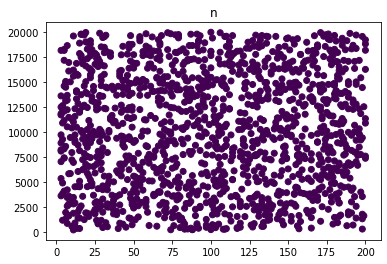

In [9]:
plt.scatter(dat['richness'], dat['abundance'], c= dat['n_hill1'])
plt.title("n")


### Train/test split

In [10]:
train_dat = dat.sample(frac = 0.7, replace = False, random_state = 0)

test_dat = dat.drop(train_dat.index)

train_X = train_dat[['richness', 'abundance']]
train_Y = train_dat[['mean', 'sd']]


test_X = test_dat[['richness', 'abundance']]
test_Y = test_dat[['mean', 'sd']]

Text(0.5, 1.0, 'Train (blue) and test (pink) points')

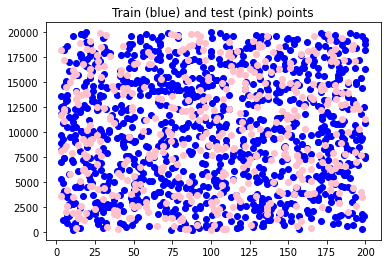

In [11]:
plt.scatter(train_X['richness'], train_X['abundance'], color = 'blue')
plt.scatter(test_X['richness'], test_X['abundance'], color = 'pink')
plt.title("Train (blue) and test (pink) points")

Text(0.5, 1.0, 'Mean')

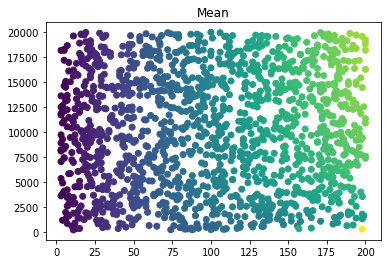

In [12]:
plt.scatter(dat['richness'], dat['abundance'], c= dat['mean'])
plt.title("Mean")

Text(0.5, 1.0, 'sd')

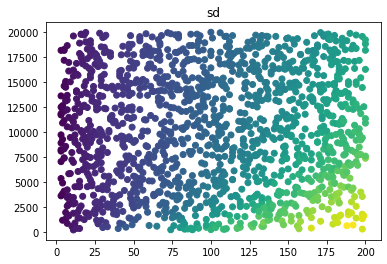

In [13]:
plt.scatter(dat['richness'], dat['abundance'], c= dat['sd'])
plt.title("sd")

In general there's this nice gradient-like, but oddly nonlinear relationship where mean increases with increasing s&n and sd increases with increasing S and decreases with increasing N.

But there are pronounced weirdos/an inversion of this pattern. I am _filtering those out for now_ (!!!)


### Normalization layer for keras

In [14]:
normalizer = tf.keras.layers.Normalization(axis = -1)
normalizer.adapt(np.array(train_X))

2023-04-18 13:28:14.463452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Models

In [15]:
test_results = {}

### Linear regression

(Multiple linear regression implemented using keras)

In [16]:
#### Mean

In [17]:
lm = tf.keras.Sequential([
    normalizer,
    layers.Dense(units = 1)
])

lm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.1),
    loss = "mean_squared_error",
    metrics=[RSquare()]
)

In [18]:
%%time

lm_history = lm.fit(
    train_X,
    train_Y['mean'],
    epochs = 500,
    verbose = 0,
    validation_split = .2
)

CPU times: user 19.6 s, sys: 1.61 s, total: 21.2 s
Wall time: 16.9 s


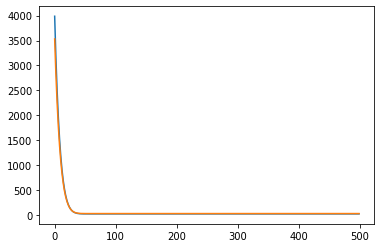

In [19]:
plt.plot(lm_history.history['loss'], label = 'loss')
plt.plot(lm_history.history['val_loss'], label = 'val_loss')

In [20]:
test_results['lm_mean_r2'] = lm.evaluate(
    test_X, test_Y['mean'], verbose=0)[1]


#### sd

In [21]:
lm_sd = tf.keras.Sequential([
    normalizer,
    layers.Dense(units = 1)
])

lm_sd.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.1),
    loss = "mean_squared_error",
    metrics=[RSquare()]
)

In [22]:
%%time

lm_sd_history = lm_sd.fit(
    train_X,
    train_Y['sd'],
    epochs = 500,
    verbose = 0,
    validation_split = .2
)

CPU times: user 19.6 s, sys: 1.61 s, total: 21.2 s
Wall time: 16.5 s


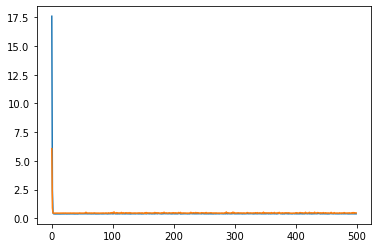

In [23]:
plt.plot(lm_sd_history.history['loss'], label = 'loss')
plt.plot(lm_sd_history.history['val_loss'], label = 'val_loss')

In [24]:
test_results['lm_sd_r2'] = lm_sd.evaluate(
    test_X, test_Y['sd'], verbose=0)[1]


In [25]:
test_results

{'lm_mean_r2': 0.9761756658554077, 'lm_sd_r2': 0.9374315142631531}

### DNN

#### Mean

In [26]:
dnn_mean = keras.Sequential([
    normalizer,
    layers.Dense(64, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1)
])

dnn_mean.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.1),
    loss = "mean_squared_error",
    metrics=[RSquare()]
)

CPU times: user 22.3 s, sys: 1.79 s, total: 24.1 s
Wall time: 18.2 s


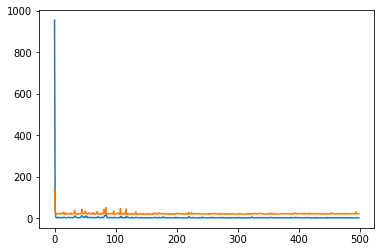

In [27]:
%%time
dnn_mean_history = dnn_mean.fit(
    train_X,
    train_Y['mean'],
    validation_split = .2,
    verbose = 0,
    epochs = 500
)

plt.plot(dnn_mean_history.history['loss'], label = 'loss')
plt.plot(dnn_mean_history.history['val_loss'], label = 'val_loss')

In [28]:
test_results['dnn_mean_r2'] = dnn_mean.evaluate(
    test_X, test_Y['mean'], verbose=0)[1]

#### sd

In [29]:
dnn_sd = keras.Sequential([
    normalizer,
    layers.Dense(64, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1)
])

dnn_sd.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.1),
    loss = "mean_squared_error",
    metrics=[RSquare()]
)



CPU times: user 22.5 s, sys: 1.81 s, total: 24.3 s
Wall time: 18.4 s


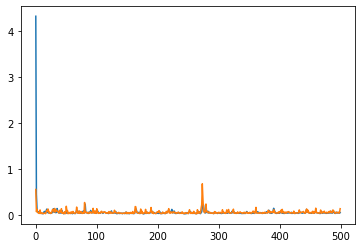

In [30]:
%%time
dnn_sd_history = dnn_sd.fit(
    train_X,
    train_Y['sd'],
    validation_split = .2,
    verbose = 0,
    epochs = 500
)

plt.plot(dnn_sd_history.history['loss'], label = 'loss')
plt.plot(dnn_sd_history.history['val_loss'], label = 'val_loss')

In [31]:
test_results['dnn_sd_r2'] = dnn_sd.evaluate(
    test_X, test_Y['sd'], verbose=0)[1]

### RF

#### Mean

In [32]:
rf_mean = RandomForestRegressor()
rf_mean.fit(train_X, train_Y['mean'])

RandomForestRegressor()

In [33]:
test_results['rf_mean_r2'] = rf_mean.score(test_X, test_Y['mean'])

#### sd

In [34]:
rf_mean = RandomForestRegressor()
rf_mean.fit(train_X, train_Y['sd'])
test_results['rf_sd_r2'] = rf_mean.score(test_X, test_Y['sd'])

## Model scores and vis

### Scores

In [35]:
pd.DataFrame(test_results, index=['R2']).T


,R2
lm_mean_r2,0.976176
lm_sd_r2,0.937432
dnn_mean_r2,0.997661
dnn_sd_r2,0.979914
rf_mean_r2,0.998990
rf_sd_r2,0.995861


### Vis plot